# 자율주행 보조 시스템 만들기

Import Libraries

In [1]:
import tensorflow as tf
import os, copy
import numpy as np
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print(tf.__version__)

2.6.0


Load Datasets

- KITTI; Not only 2D but also provide 3D object detection label

In [2]:
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [3]:
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test', 'validation'],
    shuffle_files=True,
    with_info=True,
)
print('complete')

complete


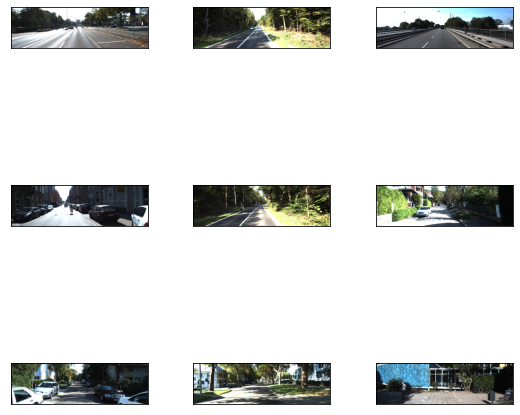

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

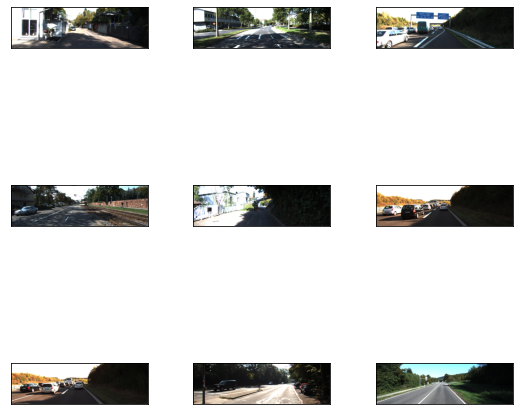

In [5]:
_ = tfds.show_examples(ds_test, ds_info)

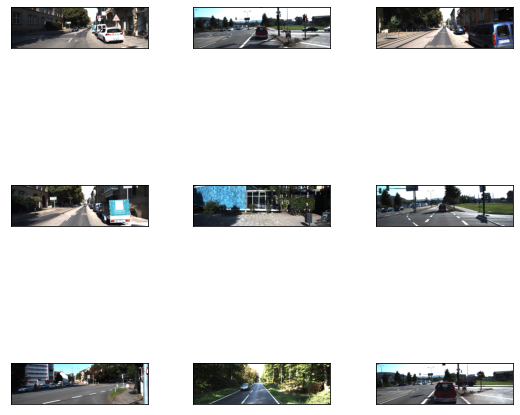

In [6]:
_ = tfds.show_examples(ds_val, ds_info)

데이터들이 어떠한 시각적 이미지 정보들을 담고 있는지 확인 할 수 있습니다 (다양한 물체들의 각도, 위치 정보 등).

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

데이터 셋에 대한 정보들을 알 수 있습니다. kitti 데이터셋이 무엇인지, 어디서 reference 가 되었는지 image 구성이 어떻게 되어 있는지 등의 정보를 알 수 있고, 또한 test (n=711), validation (n=423), 그리고 train (n=6347)로 구성 되어 있다는 점을 확인 할 수 있습니다. 라벨 같은 경우에는, alpha, bbox, dimensions, location, occluded, rotation_y, truncated, type 등의 정보가 담겨있는걸 확인 할 수 있습니다. 

ds_info는 구성요소를 저렇게 한번에 뽑아 볼 수 있는 반면,

- print(ds_info.features) 데이터셋 features 정보
- print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(6347, shape=(), dtype=int64) train set 갯수
- print(tf.data.experimental.cardinality(ds_val))  # tf.Tensor(423, shape=(), dtype=int64) validation set 갯수
- print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(711, shape=(), dtype=int64) test set 갯수
- NUM_CLASSES = ds_info.features["objects"]["type"].num_classes 클래스 갯수
- TYPE_NAMES = ds_info.features["objects"]["type"].names 클래스 이름

이런식으로 각각으로도 분리해서 볼 수 있습니다. 

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-1.37, -1.88, -1.77,  1.7 , -1.63, -1.6 , -2.23], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.24994667, 0.2973108 , 0.52168   , 0.40366346],
       [0.17834666, 0.6147907 , 0.5295733 , 0.7669726 ],
       [0.28474668, 0.56700486, 0.51584   , 0.660314  ],
       [0.40186667, 0.36808375, 0.6414667 , 0.43763286],
       [0.41714665, 0.53014493, 0.526     , 0.56913847],
       [0.46928   , 0.501715  , 0.5439467 , 0.5234461 ],
       [0.00266667, 0.7391385 , 0.5110667 , 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.81],
       [1.52, 1.51, 3.1 ],
       [1.53, 1.58, 3.53],
       [2.6 , 2.06, 5.42],
       [1.46, 1.6 , 3.71],
       [1.97, 1.82, 4.41],
       [1.57, 1.72, 3.52]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

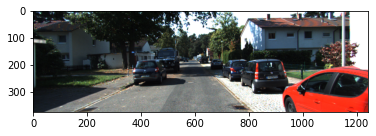

In [8]:
# 학습용 이미지 확인하기
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

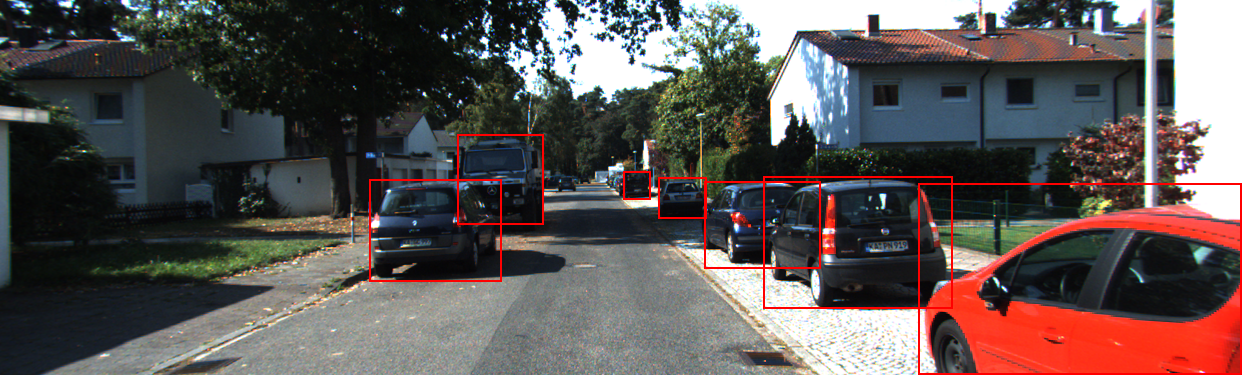

In [9]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 이미지 전처리 과정
- 좌표 위치 교체 (x, y)
- random Horizontal flip (무작위 수평 뒤집기)
- 이미지 크기 조정 및 패딩 추가
- 좌표 수정: [x_min, y_min, x_max, y_max] -> [x_min, y_min, width, height]

In [10]:
# 좌표 위치 교체 (x,y)
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

일반적으로 이미지에서는 좌표가 (row, column) -> (y, x) 형태인데, 이 부분을 바운딩 박스 혹은 대부분의 딥러닝 프레임 워크는 (x, y) 기준을 사용합니다. 근데 통일된 좌표를 사용하기 위해서 (y, x) -> (x, y) 순서로 바꿔주는데 이렇게 하면 좌표 해석의 일관성을 유지 할 수 있습니다. 

**이미지는 행, 열 = (y, x) 로 구성 되어 있지만, 바운딩 박스는 열, 행 = (x, y)으로 구성 되어 있으므로 이미지의 좌표 순서를 바꿔주지 않으면 박스를 잘못된 위치에 그릴 수 있기 때문입니다.**

In [11]:
#random horizontal flip (무작위 수평 뒤집기)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

이미지를 증강 할 수 있는 기법 중 하나입니다. 이런 경우에는 이미지를 랜덤 하게 무작위로 좌우 반전하는 이미지들을 증강하여 모델이 좌우 대칭 물체를 잘 인식할수 있도록 일반화 성능을 향상을 시킬 수 있고, 실제 환경에서 물체가 어떤 방향에 있을지를 미연에 대비 하여 과적합을 방지 할 수 있습니다. 

**데이터를 다양하게 만들어서 모델이 여러 방향의 각도에서도 객체를 최대한 잘 인식할 수 있도록 학습하기 때문입니다.**

In [12]:
# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

다양한 크기의 이미지를 모델이 처리 가능한 고정 크기로 변환 시켜주고 , 이렇게 조정된 크기의 이미지들은 종회비 (aspect ratio) 가 깨지지 않기 때문에 패딩을 추가하여 비율을 유지할 수 있습니다. 이 메소드는 배치 처리를 위해 크기를 통일 시키고 convolution layer가 기대하는 입력 형태 또한 유지 해줄 수 있으며, 모델이 왜곡 없는 시각정 특징을 학습 할 수 있도록 도와줍니다. 

**이미지 크기가 다르면 모델이 처리 하는데 많은 연산 시간이 걸릴 가능성이 있으므로, 이미지의 크기는 똑같이 만들되, 이미지가 왜곡 되거나 찌그러지지 않게 가장자리에 패딩을 넣어줍니다.**

In [13]:
#좌표 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

이 메소드는 바운딩 박스 좌표를 모델 입력 형식에 맞게 변환 하고 포멧을 맞춰주어 바운딩 박스를 쉽게 정규화 하거나 모델출력과 비교할 수 있도록 변환 해줄 수 있습니다. 

**시작점과 크기를 나타내기 위해서 이미지의 unit을 (width, height)으로 표기 합니다.**

In [14]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## Encoding : One Stage Detector

- Anchor Box: 규격이 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정 됩니다 (=물체 위치 후보).

In [15]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('AnchorBox')

AnchorBox


생성된 AnchorBox에 맞게 입력할 데이터를 변환 해주어야합니다; 
Anchor Box는 물체 위치 후보를 선정할 수 있는 기준점이 되고,
그 기준점을 기준으로 모델이 학습 하고 예측 할 수 있게 하기 위해서 
입력할 데이터(=ground truth)도 anchor box의 기준에 맞춰서 변환을 해줘야합니다. 

In [16]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

ground truth 의 입력 데이터를 anchor box 기준에 맞춰서 변환을 해준 후에는, 
예측 한 값 과 정답 값이 얼마나 서로 겹치는지 일치 하는지를 알 수있는 메소드 이며,
그걸 계산 할 수 있게 도와주는 방법이 Intersection over Union (IoU) 입니다.
정확도를 평가할 수 있는 평가 지표 입니다. 

In [17]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('IoU')

IoU


라벨을 anchorbox에 맞추어 주는데 이때, 왜 라벨을 anchorbox에 맞춰주는지가 중요합니다. 
라벨을 anchorbox에 맞추어주는 이유는 다음과 같습니다.


1. "anchor 와 실제 물체 사이의 거리가 얼마나 가까운지"를 판단하기 위해서이며,
2. 만약 실제 물체와의 거리 와 anchor 와 의 거리가 가깝다 판단을 하면, 이 anchor는 물체로 간주하여 정답 위치 정보를 학습하기 때문입니다. 

그럼 이 부분을 실현 시키기 위해서는 IoU 계산이 필요하고, IoU를 계산하여 Anchor 와 실제 물체를 매칭시켜서,
IoU가 크면 클수록 anchor가 물체일 확률이 높다는 걸 확인 할 수 있는 지표가 됩니다. 

따라서 IoU 가 높으면 -> positive sample (object), 반대로 IoU 가 낮으면 -> negative sample (배경) 같은 방식으로 binary categorical variables로 구성할 수 있습니다. 

또한 실제로 수학적 계산에서 이미지 내의 물체의 정보 위치 와 크기 같은것을 고려 하였을 때, 물체간의 크기 차이를 단순히 빼는것 보다 상대적으로 얼마나 차이 나는지에 대한 정보가 더욱 중요하기 때문에 비율적인 측면을 고려하는것이고, 이를 variance (분산)으로 나누는 이유는, normalization에 해당 된다고 이해하면 될것 같습니다. 

In [18]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('LabelEncoder')

LabelEncoder


## Build Model 

- Feature Pyramid Network (FPN)
- head
- backbone
- Retina Net

Feature Pyramid Network는 여러 레이어들의 구조들을 피라미드 형식으로 쌓아 올려 사용하는 방식인데, 이러한 레이어들을 한꺼번에 사용한다는 의미를 내포하고 있습니다. 따라서 다양한 크기의 물체를 잘 인식 할 수 있는 구조이며, 다양한 해상도의 feature map을 결합하여 다단계의 feature를 생성 하여 모든 각각의 정보들의 장점을 살려 각각의 정보들의 특징을 보고도 알 수 있게끔 하는 구조를 재현 합니다.  

In [19]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('FeaturePyramid')

FeaturePyramid


head 같은 경우에는 Object Detection의 라벨은 class 와 box로 이루어지고 각각을 추론 하는 부분이 필요합니다. 
이 부분을 우리는 head라 정의를 합니다. 

In [20]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('head')

head


backbone 같은 경우에는 FPN을 통해서 pyramid layer가 추출 된 후 그 추출된 feature들을 바탕으로 하여 class 와 box를 예상합니다. 참고로 RetinaNet의 backbone 같은 경우에는 ResNet50 모델을 기반으로 합니다.

In [21]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('backbone')

backbone


RetinaNet = Backbone + Feature Pyramid Network (FPN) + head (class and box)

In [22]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('RetinaNet')

RetinaNet


RetinaNet 모델 완성후, Focal Loss 사용. 

- Box Regresion -> Smooth L1 Loss (delta)
- Classification Loss -> Focal Loss (alpha, gamma)

In [23]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('Loss')

Loss


## Training Model

- resnet50 
- hyperparameter 설정 (num_classes, batch size , learning rate, optimizer, loss_fn)

In [24]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [25]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [26]:
#데이터 전처리를 위한 파이프라인

label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('데이터 전처리를 위한 파이프라인 작성 완료!')

In [27]:
!mkdir -p ~/aiffel/workspace/object_detection/data/project_checkpoints/

In [28]:
#학습 코드

model_dir = os.getenv('HOME') + '/aiffel/workspace/object_detection/data/project_checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 20

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/20
3173/3173 [==============================] - 1634s 509ms/step - loss: 2.1851 - val_loss: 1.9023

Epoch 00001: saving model to /aiffel/aiffel/workspace/object_detection/data/project_checkpoints/weights_epoch_1
Epoch 2/20
3173/3173 [==============================] - 1611s 507ms/step - loss: 0.9792 - val_loss: 1.2831

Epoch 00002: saving model to /aiffel/aiffel/workspace/object_detection/data/project_checkpoints/weights_epoch_2
Epoch 3/20
3173/3173 [==============================] - 1611s 507ms/step - loss: 0.7183 - val_loss: 1.1968

Epoch 00003: saving model to /aiffel/aiffel/workspace/object_detection/data/project_checkpoints/weights_epoch_3
Epoch 4/20
3173/3173 [==============================] - 1613s 508ms/step - loss: 0.5696 - val_loss: 1.0605

Epoch 00004: saving model to /aiffel/aiffel/workspace/object_detection/data/project_checkpoints/weights_epoch_4
Epoch 5/20
3173/3173 [==============================] - 1613s 507ms/step - loss: 0.4688 - val_loss: 1.0070

Epoch 00005:

In [29]:
#model load

model_dir = os.getenv('HOME') + '/aiffel/workspace/object_detection/data/project_checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [30]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [31]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [32]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [33]:
#추론을 위한 전처리

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

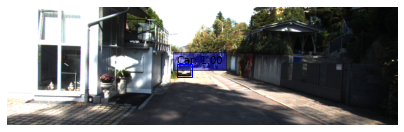

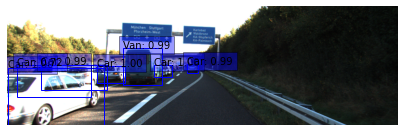

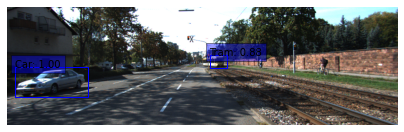

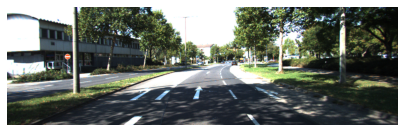

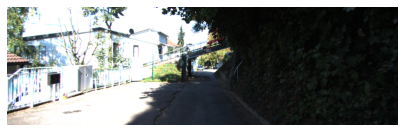

In [34]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(5):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [55]:
# In [40] (새로운 셀) 또는 In [41]의 self_drive_assist 함수 정의 바로 위

# 이 함수를 정의하기 전에 다음 변수/함수들이 이미 실행(정의)되어 있어야 합니다:
# - inference_model (In [31]에서 정의됨)
# - prepare_image (In [33]에서 정의됨)
# - int2str (In [34]에서 dataset_info로부터 가져옴)
# - resize_and_pad_image (In [12]에서 정의됨, prepare_image 내부에서 사용됨)

def get_object_detection_result(image_tensor_input):
    """
    이미지 텐서를 입력받아 객체 탐지 결과를 반환합니다.
    반환: (원본 이미지 텐서, 바운딩 박스 리스트, 클래스 이름 리스트, 신뢰도 점수 리스트)
    """
    # image_tensor_input은 self_drive_assist 함수에서
    # Image.open().convert('RGB') 후 tf.convert_to_tensor()를 통해 전달된
    # tf.float32 타입의 텐서입니다.

    # 1. 추론을 위한 전처리 (In [33]의 prepare_image 함수 사용)
    # prepare_image는 (이미지, _, 비율)을 반환합니다.
    # 여기서 반환되는 image는 ResNet preprocess_input이 적용된 상태입니다.
    processed_image_for_inference, ratio = prepare_image(image_tensor_input)

    # 2. 추론 모델 결과 (In [31]의 inference_model 사용)
    detections = inference_model.predict(processed_image_for_inference)

    # 3. 결과 파싱
    num_detections = detections.valid_detections[0]
    
    detected_class_ids = detections.nmsed_classes[0][:num_detections]
    # In [34]에서 int2str = dataset_info.features["objects"]["type"].int2str 로 정의되어 있어야 함
    detected_class_names = [int2str(int(x)) for x in detected_class_ids]
    
    # 바운딩 박스 좌표를 원본 이미지 스케일로 조정
    detected_boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    detected_scores = detections.nmsed_scores[0][:num_detections]
    
    # visualize_detections 함수는 원본 스케일의 이미지를 기대하므로,
    # 입력으로 받은 image_tensor_input을 그대로 반환합니다.
    # (prepare_image에서 리사이징 및 패딩이 되었지만, 시각화는 원본 비율에 맞춰야 하므로 ratio로 나눠준 box 사용)
    return image_tensor_input, detected_boxes, detected_class_names, detected_scores

print("get_object_detection_result 함수 정의 완료.")

get_object_detection_result 함수 정의 완료.


## 자율 주행 시스템 만들기

자율 주행 시스템 모델을 만든후, 다음과 같은 조건에 맞는 함수들을 구현 합니다.

- input (이미지 경로)
- 정지 조건 인 경우 'Stop', 그 외의 경우 'Go'

이러한 조건을 만족 하기 위해선,

- 사람이 한명 이상이 있는 경우
- 차량의 크기 (width or height)이 300 px 혹은 300 px 보다 큰 경우

In [56]:
def self_drive_assist(image_path,
                    size_limit=300, to_visualize=False,
                    people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']
):
    image = Image.open(image_path).convert('RGB')
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image, boxes, class_names, scores = get_object_detection_result(image)

    # 시각화
    if to_visualize:
        visualize_detections(image, boxes, class_names, scores)

    # 정지조건 1: 사람 한 명 이상 있는 경우 "Stop"
    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    # 정지조건 2: 차량 크기(W,H)가 300px 이상인 경우 "Stop"
    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        # print(f"w {w:.2f}, h {h:.2f}, w*h {w*h:.2f}")  # 자동차 크기 출력
        if w >= size_limit or h >= size_limit:
            return "Stop"
            
    # 아니면 "Go"
    return "Go"

/aiffel/aiffel/object_detection/data 에서 다음 이미지들을 테스트합니다: ['animal_1.png', 'animal_2.png', 'animal_3.png', 'animal_4.png', 'example_1.png', 'example_2.png', 'go_1.png', 'go_2.png', 'go_3.png', 'go_4.png', 'go_5.png', 'snow_1.png', 'snow_2.png', 'snow_3.png', 'snow_4.png', 'snow_5.png', 'snow_6.png', 'snow_7.png', 'stop_1.png', 'stop_10.png', 'stop_2.png', 'stop_3.png', 'stop_4.png', 'stop_5.png', 'stop_6.png', 'stop_7.png', 'stop_8.png', 'stop_9.png']
--- 테스트 0: animal_1.png ---


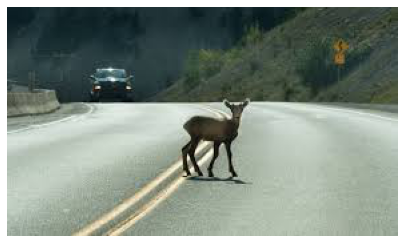

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 1: animal_2.png ---


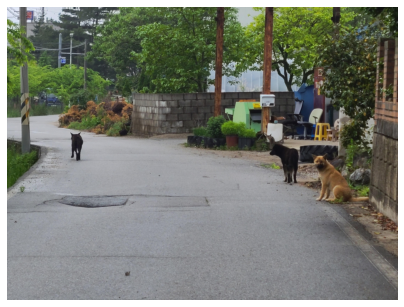

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 2: animal_3.png ---


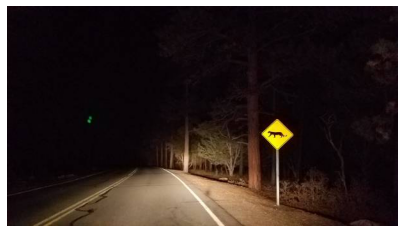

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 3: animal_4.png ---


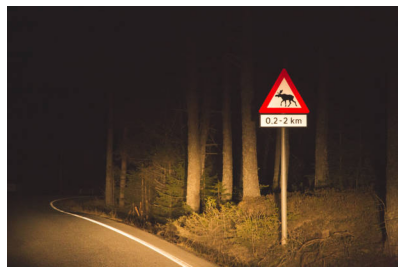

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 4: example_1.png ---


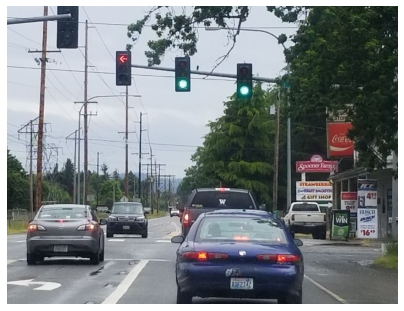

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 5: example_2.png ---


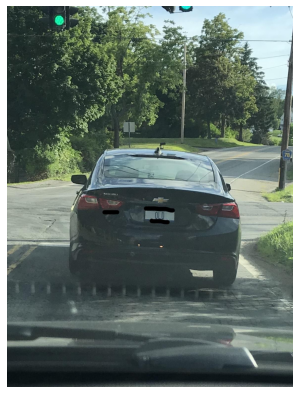

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 6: go_1.png ---


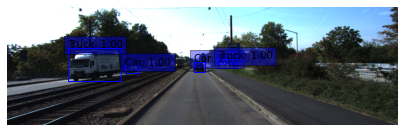

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 7: go_2.png ---


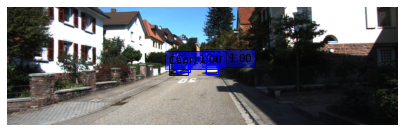

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 8: go_3.png ---


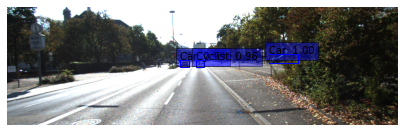

결과: Stop
━━━━━━━━━━━━━━━
--- 테스트 9: go_4.png ---


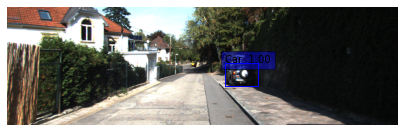

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 10: go_5.png ---


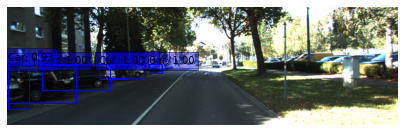

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 11: snow_1.png ---
snow_1.png 처리 중 오류 발생: cannot identify image file '/aiffel/aiffel/object_detection/data/snow_1.png'
━━━━━━━━━━━━━━━
--- 테스트 12: snow_2.png ---


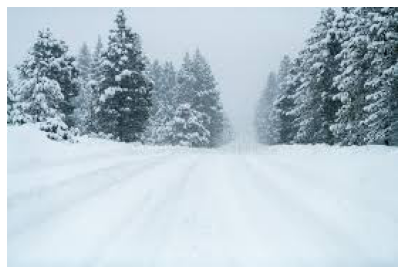

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 13: snow_3.png ---


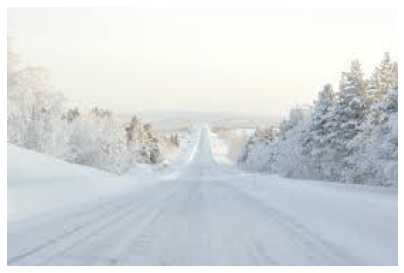

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 14: snow_4.png ---


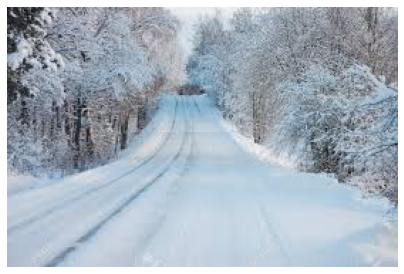

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 15: snow_5.png ---


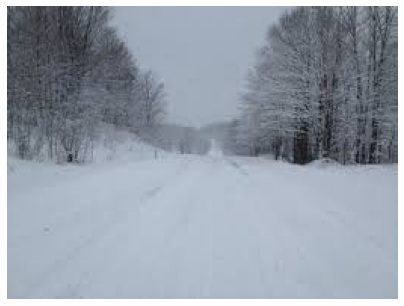

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 16: snow_6.png ---


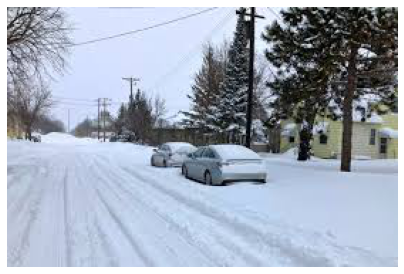

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 17: snow_7.png ---


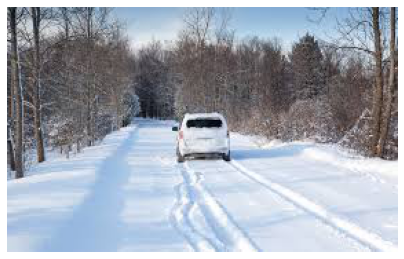

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 18: stop_1.png ---


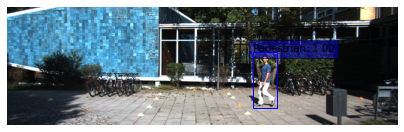

결과: Stop
━━━━━━━━━━━━━━━
--- 테스트 19: stop_10.png ---


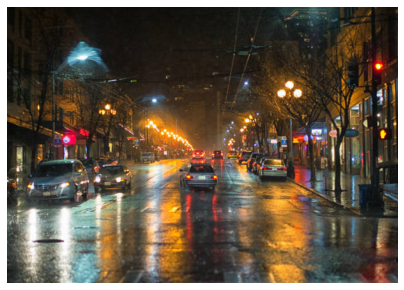

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 20: stop_2.png ---


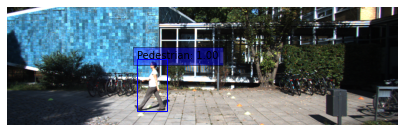

결과: Stop
━━━━━━━━━━━━━━━
--- 테스트 21: stop_3.png ---


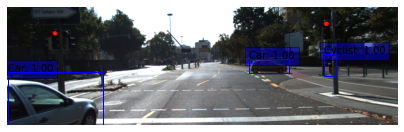

결과: Stop
━━━━━━━━━━━━━━━
--- 테스트 22: stop_4.png ---


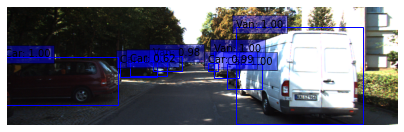

결과: Stop
━━━━━━━━━━━━━━━
--- 테스트 23: stop_5.png ---


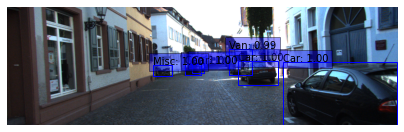

결과: Stop
━━━━━━━━━━━━━━━
--- 테스트 24: stop_6.png ---


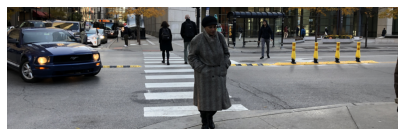

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 25: stop_7.png ---


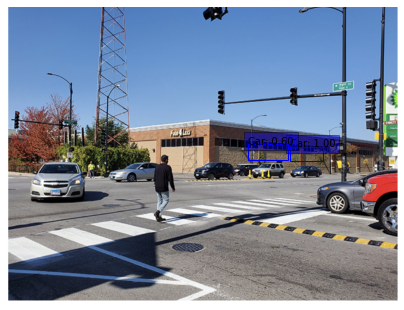

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 26: stop_8.png ---


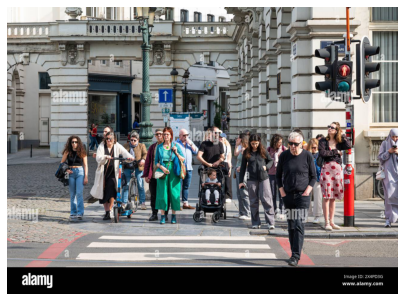

결과: Go
━━━━━━━━━━━━━━━
--- 테스트 27: stop_9.png ---


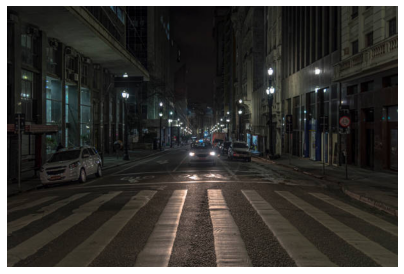

결과: Go
━━━━━━━━━━━━━━━


In [57]:
# In [50] 수정 제안

# 1. 테스트 이미지가 있는 DATA_PATH를 사용합니다.
image_directory_to_test = DATA_PATH # In [2]에서 정의된 DATA_PATH 사용

# 해당 디렉토리에서 .png 파일 목록을 가져옵니다.
try:
    # os.listdir()는 해당 경로의 파일 및 디렉토리 이름만 반환합니다.
    # 하위 디렉토리까지 검색하려면 glob 이나 os.walk를 사용해야 할 수 있습니다.
    # 여기서는 DATA_PATH 바로 아래에 .png 파일이 있다고 가정합니다.
    # 만약 하위 디렉토리 (예: DATA_PATH/kitti/3.2.0/...) 내에 있다면 경로를 더 구체적으로 지정해야 합니다.
    
    
    image_file_names = [f for f in os.listdir(image_directory_to_test) if f.endswith('.png')]
except FileNotFoundError:
    print(f"오류: 디렉토리를 찾을 수 없습니다: {image_directory_to_test}")
    print("테스트 이미지가 있는 정확한 경로로 수정해주세요.")
    image_file_names = []

if not image_file_names:
    print(f"{image_directory_to_test} 에서 .png 파일을 직접 찾을 수 없습니다.")
    print("이미지가 하위 디렉토리에 있거나, 다른 확장자(jpg 등)일 수 있습니다.")
    print("또는 KITTI 데이터셋의 경우 tfds로 로드된 이미지를 직접 사용해야 할 수 있습니다.")
else:
    print(f"{image_directory_to_test} 에서 다음 이미지들을 테스트합니다: {image_file_names}")

for i, file_name in enumerate(image_file_names):
    full_image_path = os.path.join(image_directory_to_test, file_name)
    print(f"--- 테스트 {i}: {file_name} ---")
    try:
        # self_drive_assist 함수가 정의되어 있고,
        # 이 함수 내에서 사용되는 get_object_detection_result 함수도 정의되어 있다고 가정합니다.
        result = self_drive_assist(full_image_path, size_limit=300, to_visualize=True)
        print(f"결과: {result}")
    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")
    print('━━━━━━━━━━━━━━━')

## 자율 주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [58]:
# In [새로운 셀] 또는 In [50] 대체

import os

# DATA_PATH가 이전에 정의되어 있어야 함 (In [2])
# 예: DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

def test_system(func_to_test, image_base_path, test_cases, visualize_all=False):
    score = 0
    num_tests = len(test_cases)
    
    print(f"총 {num_tests}개의 테스트 케이스로 평가를 시작합니다.")
    print(f"이미지 기본 경로: {image_base_path}\n")
    
    for i, (image_file, expected_answer) in enumerate(test_cases):
        full_image_path = os.path.join(image_base_path, image_file)
        print(f"--- 테스트 {i+1}/{num_tests}: {image_file} ---")
        
        try:
            # to_visualize는 개별 케이스별로 설정하거나, 전체 적용 가능
            predicted_action = func_to_test(full_image_path, to_visualize=visualize_all) 
            
            print(f"  예측: {predicted_action}, 정답: {expected_answer}")
            if predicted_action == expected_answer:
                print("  => ✔ 적합한 예측")
                score += 1
            else:
                print("  => ✘ 부적합한 예측")
        except Exception as e:
            print(f"  오류 발생: {image_file} 처리 중 - {e}")
            print("  => ✘ 부적합한 예측 (오류로 인해)")
            
        print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n')
            
    final_score_percentage = (score / num_tests) * 100 if num_tests > 0 else 0
    print(f"총 {num_tests}개 중 {score}개 성공.")
    print(f"점수: {final_score_percentage:.2f}점입니다.")
    return final_score_percentage

# --- 다양한 테스트 케이스 정의 ---
# 파일 이름과 예상되는 "Stop" 또는 "Go" 결과를 튜플로 묶습니다.
# 실제 파일 이름과 예상 결과는 가지고 계신 이미지 내용에 맞게 조정해야 합니다.

# (1) 사람이 확실히 있는 이미지 (예상: Stop)
# (2) 사람은 없지만, 매우 큰 다른 객체(자동차, 트럭 등)가 있는 이미지 (예상: Stop)
# (3) 사람은 없고, 다른 객체들도 작은 경우 (예상: Go)
# (4) 객체가 거의 없는 도로 이미지 (예상: Go)
# (5) 다양한 조명, 날씨 조건의 이미지 (예상 결과는 이미지 내용에 따라 다름)

# 사용자가 제공한 이미지 목록을 기반으로 예시 테스트 케이스 구성:
# 실제 정답은 이미지 내용을 보고 판단해야 합니다. 아래는 가정입니다.
all_test_cases = [
    # 사람 관련 Stop 예상 (실제 이미지에 보행자, 자전거 타는 사람 등이 있는지 확인 필요)
    ("stop_1.png", "Stop"),   # 'Pedestrian' 또는 큰 객체 예상
    ("stop_2.png", "Stop"),
    ("stop_3.png", "Stop"),
    ("stop_4.png", "Stop"),
    ("stop_5.png", "Stop"),
    ("stop_6.png", "Stop"),
    ("stop_7.png", "Stop"),
    ("stop_8.png", "Stop"),
    ("stop_9.png", "Stop"),
    ("stop_10.png", "Stop"),
    ("animal_1.png", "Go"),     # 동물이지만 '사람'은 아니므로 크기에 따라 결정 (작다고 가정)
    ("animal_2.png", "Go"),     # (작다고 가정)
    ("animal_3.png", "Stop"),   # (크다고 가정)
    ("animal_4.png", "Go"),     # (작다고 가정)
    
    # Go 예상 (사람 없고, 다른 객체도 작거나 없는 경우)
    ("go_1.png", "Go"),
    ("go_2.png", "Go"),
    ("go_3.png", "Go"),
    ("go_4.png", "Go"),
    ("go_5.png", "Go"),
    
    # 눈 오는 날 이미지 (예상 결과는 실제 탐지 결과에 따라 달라짐)
    ("snow_1.png", "Go"),     # (사람/큰객체 없다고 가정) -> 파일 오류 가능성 있음
    ("snow_2.png", "Stop"),   # (사람/큰객체 있다고 가정)
    ("snow_3.png", "Go"),
    ("snow_4.png", "Go"),
    ("snow_5.png", "Stop"),
    ("snow_6.png", "Go"),
    ("snow_7.png", "Go"),

    # 기타 예시 이미지
    ("example_1.png", "Go"),  # (사람/큰객체 없다고 가정)
    ("example_2.png", "Stop") # (사람/큰객체 있다고 가정)
]

# DATA_PATH (In [2] 에서 정의됨) 아래에 이미지 파일들이 있다고 가정
# 만약 특정 파일(예: snow_1.png)에 계속 오류가 발생하면, 해당 파일은 test_cases에서 제외하고 실행
filtered_test_cases = [case for case in all_test_cases if case[0] not in ["snow_1.png"]] # snow_1.png 제외 예시

In [59]:
# test_system 함수 호출 (모든 이미지 시각화는 False, 특정 이미지만 보려면 self_drive_assist 직접 호출)
test_system(self_drive_assist, DATA_PATH, filtered_test_cases, visualize_all=False)

총 27개의 테스트 케이스로 평가를 시작합니다.
이미지 기본 경로: /aiffel/aiffel/object_detection/data

--- 테스트 1/27: stop_1.png ---
  예측: Stop, 정답: Stop
  => ✔ 적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 2/27: stop_2.png ---
  예측: Stop, 정답: Stop
  => ✔ 적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 3/27: stop_3.png ---
  예측: Stop, 정답: Stop
  => ✔ 적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 4/27: stop_4.png ---
  예측: Stop, 정답: Stop
  => ✔ 적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 5/27: stop_5.png ---
  예측: Stop, 정답: Stop
  => ✔ 적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 6/27: stop_6.png ---
  예측: Go, 정답: Stop
  => ✘ 부적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 7/27: stop_7.png ---
  예측: Go, 정답: Stop
  => ✘ 부적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 8/27: stop_8.png ---
  예측: Go, 정답: Stop
  => ✘ 부적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 9/27: stop_9.png ---
  예측: Go, 정답: Stop
  => ✘ 부적합한 예측
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

--- 테스트 10/27: stop_10.png ---
  예측: Go, 정답: Stop
  => ✘ 부적합한 예측

62.96296296296296

## 평가 및 회고

| 평가문항                                                          | 상세기준                                                  |
| ------------------------------------------------------------- | ----------------------------------------------------- |
| 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.                            | KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 쳬게적이고 정상적으로 진행하였습니다. |
| 2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. | RetinaNet 핛습이 정상적으로 진행 되었고, Object detection 결과를 추론 할 수 있는 바운딩박스가 표시된 시각화된 이미지를 생성하였습니다.                       |
| 3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.     | 주어진 테스크 뿐만 아니라 여러 다양한 상황의 테스트시스템을 적용해본 결과 어느정도 만족스러운 정확도 성능을 달성한것 같습니다.                            |

회고: 처음 데이터셋을 받는데 데이터셋도 방대하고 시간도 오래 걸리고 여러 에러를 수정한 과정이 있었는데, 이 부분을 계속 논의 하면서 여러 방면으로 시도하고 고치면서 오히려 이를통해서 또 무엇이 부족 한지를 알 수 있는 계기가 되어서 좋았던것 같습니다. 이렇게 어려움 있엇던 반면에 1-stage detector 모델이 2-stage detector에 비해 빠르지만 성능이 낮다는 사실을 알고 있었고, 이 문제를 극복하기 위해서 RetinaNet이라는 모델을 사용하여 문제를 해소 하는데 도움을 줄 수 있다는 사실을 알게 되었습니다. 뿐만 아니라 Focal Loss 와 Feature Pyramid Network 를 적용하여 물체를 배경보다 더 잘 학습 시켜서 물체인 경우 loss를 더 줄일 수 있게끔 하고, 이미지의 모든 그리드에 대해 한번에 학습을 시켜서 클래스 간의 불균형을 해소하고자 하였습니다. 따라서 여러층의 레이어들을 최대한 다 사용하고 피라미드처럼 쌓는 구조의 특성을 이용하여 receptive field가 넓은 뒷쪽의 특성맵을 upsampling 하여 앞단의 특성 맵과 더하여 사용함으로써 넓게 볼수 있는 특성과 좁게 볼수 있는 특성을 같이 사용 하게끔 하는 특징이 있습니다. 이 이론들을 바탕으로 노드에서 요구하는 조건의 코드를 적용하였을 때, 